In [21]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


In [22]:
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

In [23]:
random_state = 42
X_scaled = X / 255.0 

Label for image 10: 3


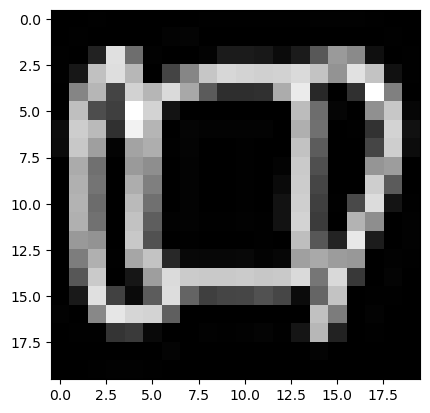

In [24]:
#vislualize

#chosen image
k=10

shape = (X[k].reshape(20,20))
flatten = shape.flatten()

print(f"Label for image {k}: {y[k]}")
plt.imshow(shape, vmin=0, vmax=255, cmap="gray")
plt.show()

In [25]:
# K-Nearest Neighbors (KNN) Classifier
# Choose a metric: "euclidean", "manhattan", "minkowski", "chebyshev", legg til hvis nødvendig
# Choose a range of k values to test or maybe just choose one?

n_neighbors = 3 # Chose one

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

knn = KNeighborsClassifier(n_neighbors=n_neighbors)

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Classifier Accuracy: {accuracy * 100:.2f}%") 

KNN Classifier Accuracy: 67.98%


In [ ]:
dataset = np.load("dataset_corrupted.npz")
X, y = dataset["X"], dataset["y"]

In [ ]:
#MLP

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

mlp = MLPClassifier(max_iter=1000, solver='adam', random_state=random_state, early_stopping=True)

paramgrid_mlp = {
    'max_iter': [500, 1000, 2000, 3000],
    'hidden_layer_sizes': [(100,50), (200,100,50), (300,200,100), (400,300,200,100)],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.05]
}

grid_mlp = GridSearchCV(mlp, paramgrid_mlp, cv=5, n_jobs=-1)
grid_mlp.fit(X_train, y_train)



y_pred_mlp = grid_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

print("Best parameters for MLP:", grid_mlp.best_params_)
print("Best MLP Accuracy:", accuracy_mlp)

#print training accuracy
y_train_pred_mlp = grid_mlp.predict(X_train)
accuracy_train_mlp = accuracy_score(y_train, y_train_pred_mlp)
print("Training Accuracy:", accuracy_train_mlp)

#print test accuracy
print("Test Accuracy:", accuracy_mlp)

plt.plot(grid_mlp.best_estimator_.loss_curve_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Training Loss Curve")
plt.show()